In [2]:
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import numpy as np
import os
import pathlib

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
def get_img_lbl(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    label = int(one_hot)
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [64, 64])
    return img, label

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(32)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

In [6]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomRotation((-1/72,1/72)), # 360deg * [-1/72; 1/72] = [-5deg; 5deg] 
    keras.layers.RandomBrightness((-0.05,0.05)), # +-5%
    keras.layers.RandomContrast(0.05), # +-5%
    keras.layers.GaussianNoise(2.5), # 95% of samples fall between -2 * st_dev and +2 * st_dev => [-5; +5]
])

model = keras.models.Sequential([
    data_augmentation,
    keras.layers.Resizing(64, 64),
    keras.layers.Rescaling(1./255,input_shape=(64, 64, 3)),
    keras.layers.Conv2D(128, 7, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="categorical_crossentropy",
 optimizer="sgd",
 metrics=["accuracy"], run_eagerly=True)

In [7]:
data_dir = pathlib.Path("./dataset/classification/")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
class_names = np.array(sorted([item.name for item in data_dir.glob('[A-D]*')]))
print(class_names)
list_ds = list_ds.repeat(50) # 20 * 50 = 1000 images of each traffic sign
image_count = len(list_ds)
print(image_count)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
train_ds = train_ds.map(get_img_lbl, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(get_img_lbl, num_parallel_calls=AUTOTUNE)
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

200
['A7' 'B2' 'B20' 'B33-30' 'B33-60' 'B36' 'B42' 'C12' 'D1' 'D6']
10000
8000
2000
Image shape:  (32, 64, 64, 3)
Label:  [[0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]]


In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30)

In [ ]:
model.save('model.keras')

In [8]:
model = tf.keras.models.load_model('first_model.keras')

In [9]:
test_list_ds = tf.data.Dataset.list_files('./dataset/classification/test/*/*.jpg')
print(len(test_list_ds))
test_ds = test_list_ds.map(get_img_lbl, num_parallel_calls=AUTOTUNE)
test_ds_copy = test_ds
test_ds = configure_for_performance(test_ds)

for image, label in test_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

model.evaluate(test_ds)

1039
Image shape:  (32, 64, 64, 3)
Label:  [[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]

33/33 [==============================] - 18s 514ms/step - loss: 0.2178 - accuracy: 0.9808


[0.21779121458530426, 0.9807507395744324]

In [10]:
from sklearn.metrics import confusion_matrix
# y_prediction = model.predict(test_ds)
# y_prediction = np.argmax(y_prediction, axis = 1)
# print(y_prediction,len(y_prediction))
y_test = []
x_test = []
for image, label in test_ds:
    y_test.append(label)
    x_test.append(image)
x_test = np.concatenate(x_test)
print(x_test)
y_prediction = model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis = 1)
y_test = np.concatenate(y_test)
y_test=np.argmax(y_test, axis=1)
print(y_test,len(y_test))
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)

[[[[ 24.663635  28.663635  27.663635]
   [ 22.914062  26.914062  25.914062]
   [ 20.195312  24.195312  23.195312]
   ...
   [ 34.023438  39.023438  32.023438]
   [ 35.548157  40.548157  33.548157]
   [ 34.742188  39.742188  32.742188]]

  [[ 20.34375   25.34375   21.34375 ]
   [ 22.582092  27.582092  23.582092]
   [ 24.203125  29.203125  25.203125]
   ...
   [ 20.914062  25.914062  18.914062]
   [ 25.29303   30.29303   23.29303 ]
   [ 28.484375  33.484375  26.484375]]

  [[ 25.730835  30.730835  25.87146 ]
   [ 27.717346  32.717346  27.857971]
   [ 30.204407  35.204407  30.345032]
   ...
   [ 27.0802    32.0802    25.0802  ]
   [ 23.834534  28.834534  21.834534]
   [ 22.        27.        20.      ]]

  ...

  [[ 44.539062  48.539062  33.539062]
   [ 38.625     42.625     27.625   ]
   [ 35.859375  39.859375  25.859375]
   ...
   [ 94.55469   86.55469   75.55469 ]
   [ 92.35297   84.35297   73.35297 ]
   [ 86.92969   78.92969   67.92969 ]]

  [[ 50.398438  53.398438  36.398438]
   [ 46

<Axes: >

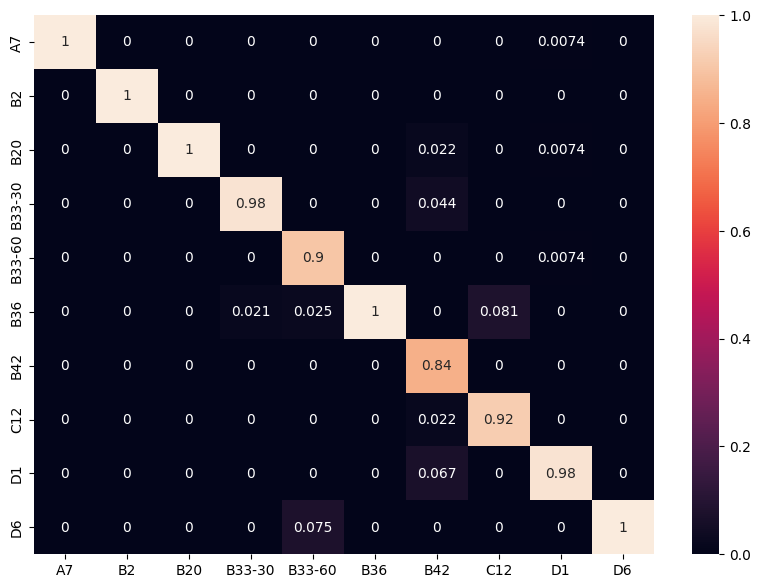

In [11]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(result, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

1/1 [==============================] - 1s 539ms/step
[9 1 1 0 8 8 4 8 5 8 1 6 5 4 0 6 8 5 1 4 0 3 0 8 0 0 0 8 8 9 5 9]
Label:  D6  Prediction:  D6
Label:  B2  Prediction:  B2
Label:  B2  Prediction:  B2
Label:  A7  Prediction:  A7
Label:  D1  Prediction:  D1
Label:  D1  Prediction:  D1
Label:  B33-60  Prediction:  D1
Label:  D1  Prediction:  D1
Label:  B36  Prediction:  B36
Label:  D1  Prediction:  D1
Label:  B2  Prediction:  B2
Label:  B42  Prediction:  B42
Label:  B36  Prediction:  B36
Label:  B33-60  Prediction:  B33-60
Label:  A7  Prediction:  A7
Label:  B42  Prediction:  B42
Label:  D1  Prediction:  D1
Label:  B36  Prediction:  B36
Label:  B2  Prediction:  B2
Label:  B33-60  Prediction:  B33-60
Label:  A7  Prediction:  A7


C:\Users\klaud\AppData\Local\Temp\ipykernel_54844\2947156676.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Label:  B33-30  Prediction:  B33-30
Label:  A7  Prediction:  A7
Label:  D1  Prediction:  D1
Label:  A7  Prediction:  A7
Label:  A7  Prediction:  A7
Label:  A7  Prediction:  A7
Label:  D1  Prediction:  D1
Label:  D1  Prediction:  D1
Label:  D6  Prediction:  D6
Label:  B36  Prediction:  B36
Label:  D6  Prediction:  D6


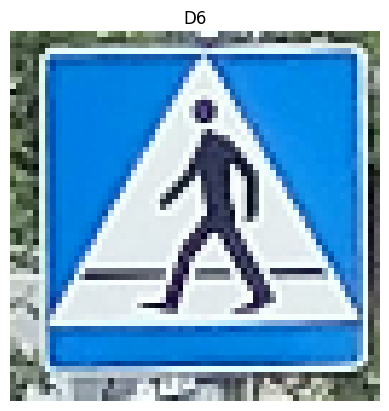

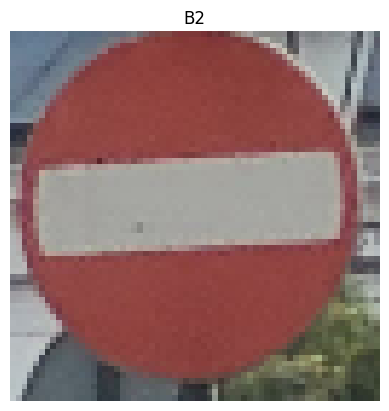

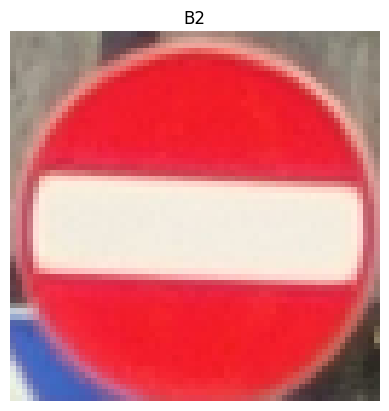

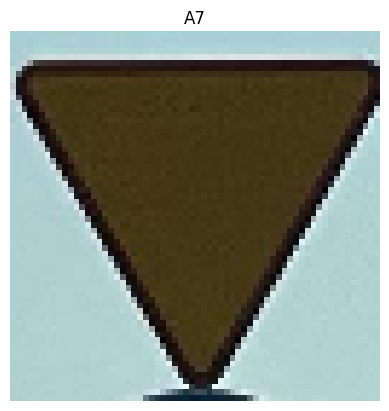

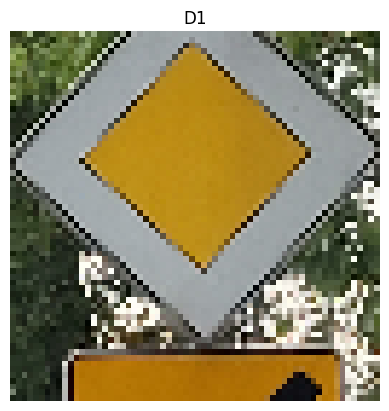

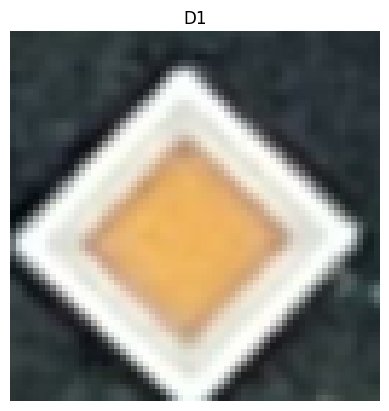

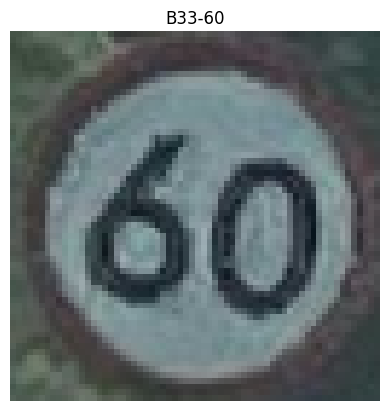

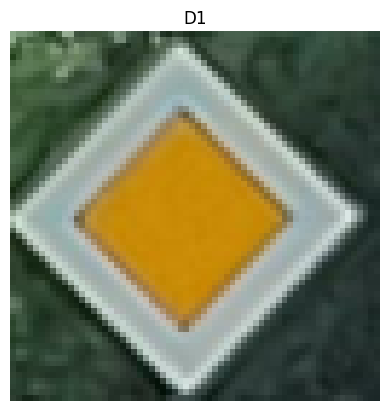

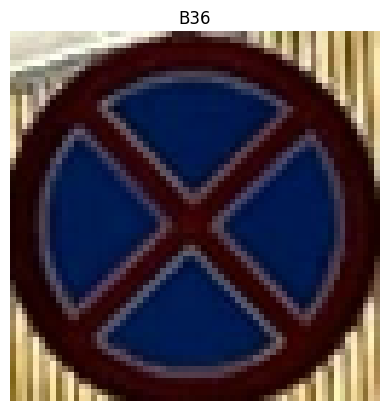

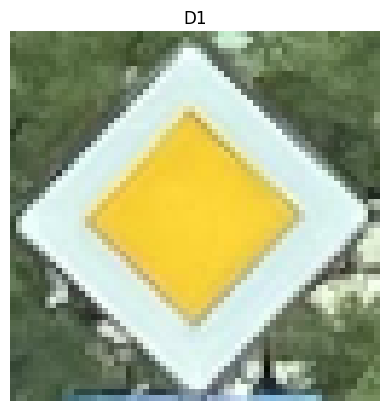

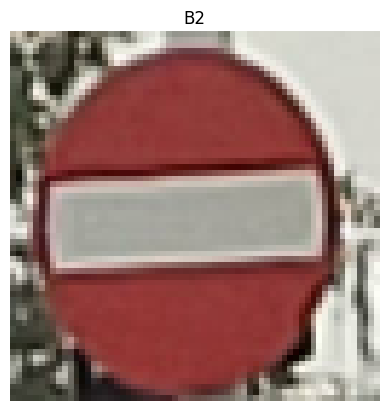

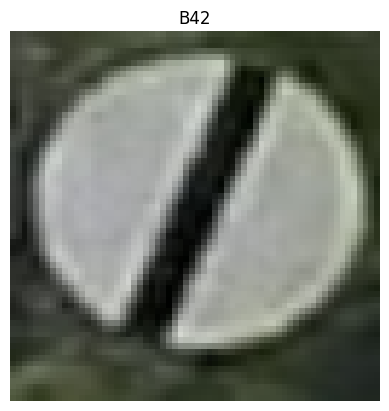

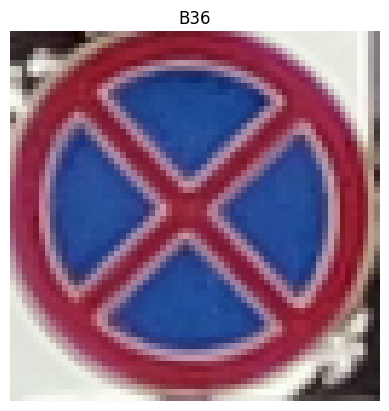

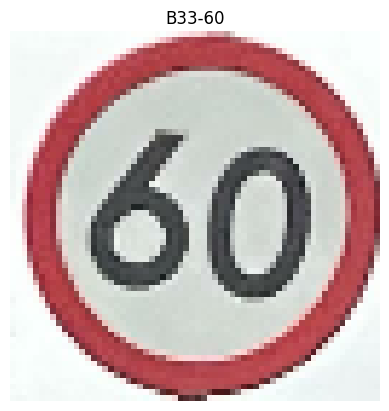

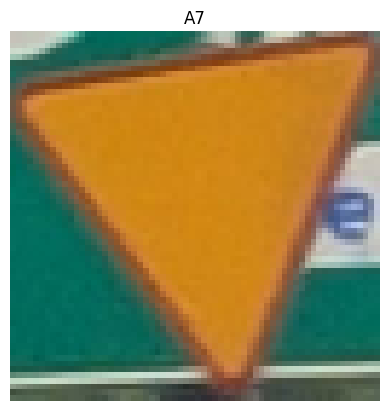

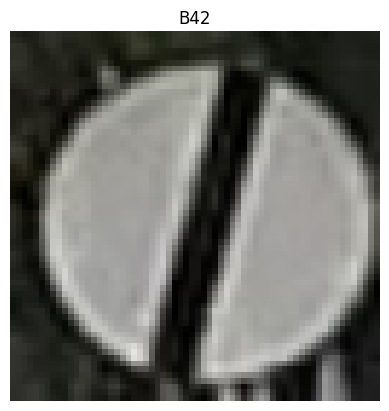

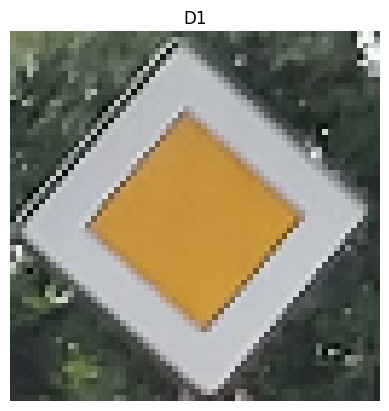

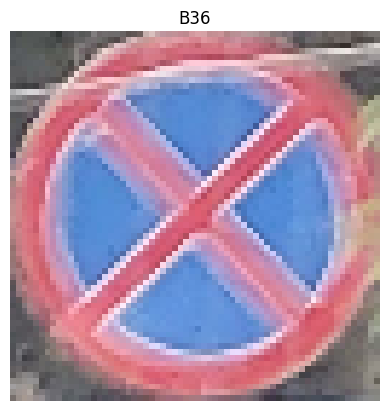

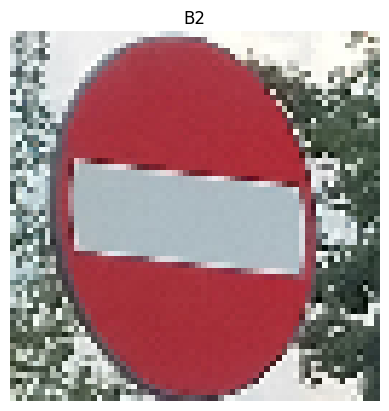

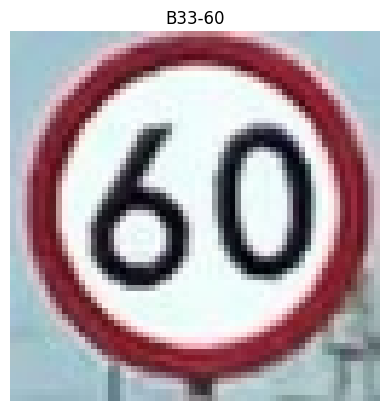

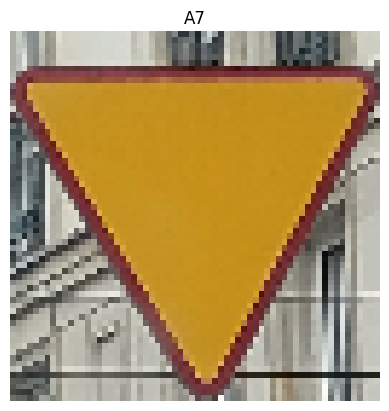

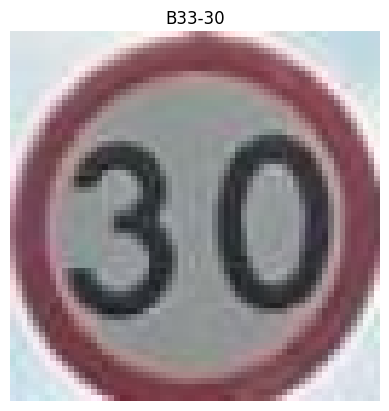

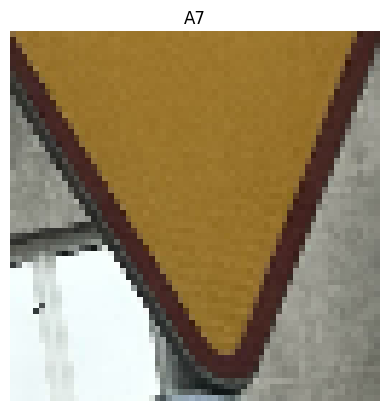

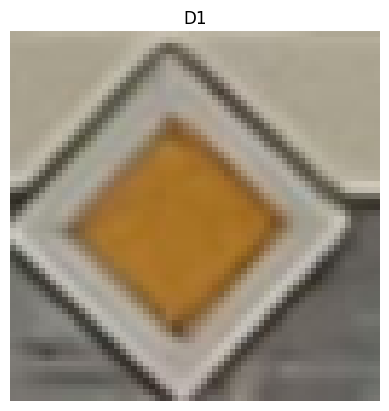

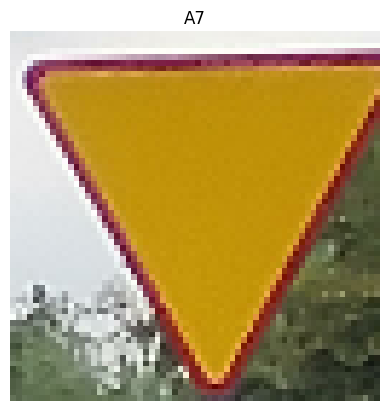

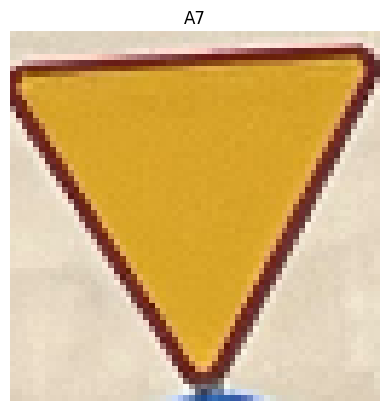

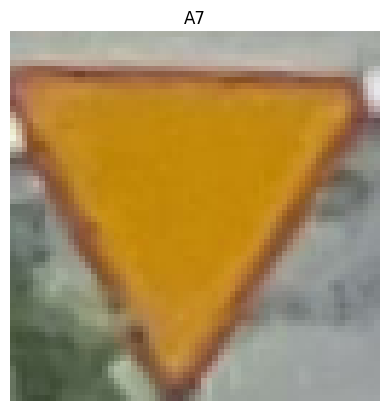

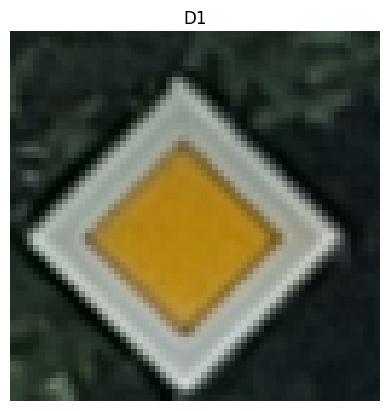

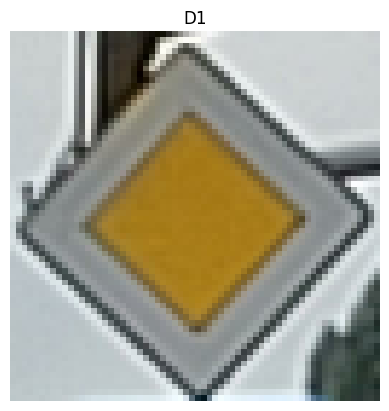

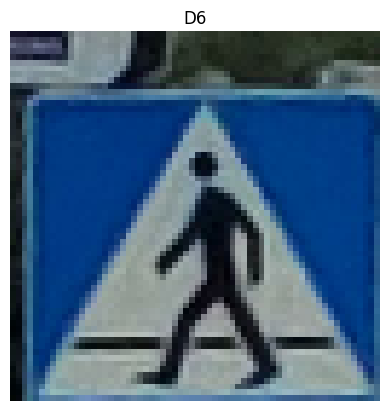

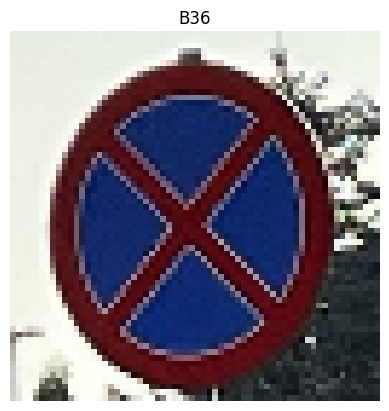

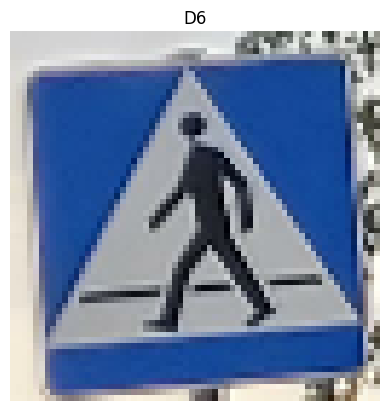

In [22]:
image_batch = test_ds.take(1)
# print(image_batch)
# predictions = model.predict(image_batch)
# print(predictions)
# print(np.argmax(predictions, axis = 1))
y_test = []
x_test = []
for images, labels in image_batch:
    y_test.append(labels)
    x_test.append(images)
# print(images)
# print(labels)
x_test = np.concatenate(x_test)
predictions = model.predict(images)
# print(predictions)
predictions = np.argmax(predictions, axis = 1)
y_test = np.concatenate(y_test)
y_test=np.argmax(y_test, axis=1)
print(y_test)
for i in range(len(y_test)):
    image= x_test[i]
    image = np.clip(image, 0, 255).astype(np.uint8)
    show(image,class_names[y_test[i]])
    print("Label: ",class_names[y_test[i]], " Prediction: ", class_names[predictions[i]])